In [2]:
import pandas as pd
import numpy as np

# ====== Load ======
df = pd.read_csv("data_out/market_with_enso_proxy_monthly.csv", parse_dates=["date"])
df = df.set_index("date").sort_index()

# Keep only relevant columns
cols = ["ADM_PRICE","BG_PRICE","SOY_PRICE",
        "enso_proxy","la_nina_index",
        "SWI_Brazil","SWI_US"]
df = df[cols]

# ====== Define seasons ======
def assign_brazil_season(ts: pd.Timestamp) -> int:
    # Brazil season runs Oct–Mar -> label by harvest year (the Jan year)
    year = ts.year
    if ts.month >= 10:   # Oct–Dec belong to next year’s season
        return year + 1
    else:
        return year

def assign_us_season(ts: pd.Timestamp) -> int:
    # US season May–Sep -> label by calendar year
    return ts.year

df["Season_BR"] = df.index.map(assign_brazil_season)
df["Season_US"] = df.index.map(assign_us_season)
df["Month"] = df.index.month

# ====== Aggregate to seasonal means ======
# Brazil season: restrict months Oct–Mar
df_br = df[df["Month"].isin([10,11,12,1,2,3])]
season_br = df_br.groupby("Season_BR").mean(numeric_only=True)

# US season: restrict months May–Sep
df_us = df[df["Month"].isin([5,6,7,8,9])]
season_us = df_us.groupby("Season_US").mean(numeric_only=True)

# ====== Correlation tests ======
def correlation_table(season_df, target, variables):
    out = {}
    for var in variables:
        if var in season_df.columns:
            corr = season_df[[target,var]].dropna().corr().iloc[0,1]
            out[var] = corr
    return pd.Series(out, name=target)

variables = ["enso_proxy","la_nina_index","SWI_Brazil","SWI_US","SOY_PRICE"]

# For ADM and BG (Brazil + US seasons separately)
corr_adm_br = correlation_table(season_br, "ADM_PRICE", variables)
corr_bg_br  = correlation_table(season_br, "BG_PRICE", variables)
corr_soy_br = correlation_table(season_br, "SOY_PRICE", variables)

corr_adm_us = correlation_table(season_us, "ADM_PRICE", variables)
corr_bg_us  = correlation_table(season_us, "BG_PRICE", variables)
corr_soy_us = correlation_table(season_us, "SOY_PRICE", variables)

# ====== Display ======
print("=== Brazil Season Correlations (Oct–Mar) ===")
print(pd.concat([corr_adm_br, corr_bg_br, corr_soy_br], axis=1))

print("\n=== US Season Correlations (May–Sep) ===")
print(pd.concat([corr_adm_us, corr_bg_us, corr_soy_us], axis=1))


=== Brazil Season Correlations (Oct–Mar) ===
               ADM_PRICE  BG_PRICE  SOY_PRICE
enso_proxy      0.536099  0.474889   0.201149
la_nina_index  -0.308116 -0.310378  -0.041049
SWI_Brazil      0.477705  0.381901   0.124417
SWI_US         -0.458301 -0.345116  -0.165898
SOY_PRICE       0.653619  0.722221   1.000000

=== US Season Correlations (May–Sep) ===
               ADM_PRICE  BG_PRICE  SOY_PRICE
enso_proxy      0.763169  0.620155   0.269052
la_nina_index  -0.393576 -0.293176  -0.013533
SWI_Brazil      0.713563  0.598280   0.229577
SWI_US          0.163640  0.020956   0.297083
SOY_PRICE       0.587637  0.664409   1.000000


=== Scatter plots – Brazil season (Oct–Mar) ===


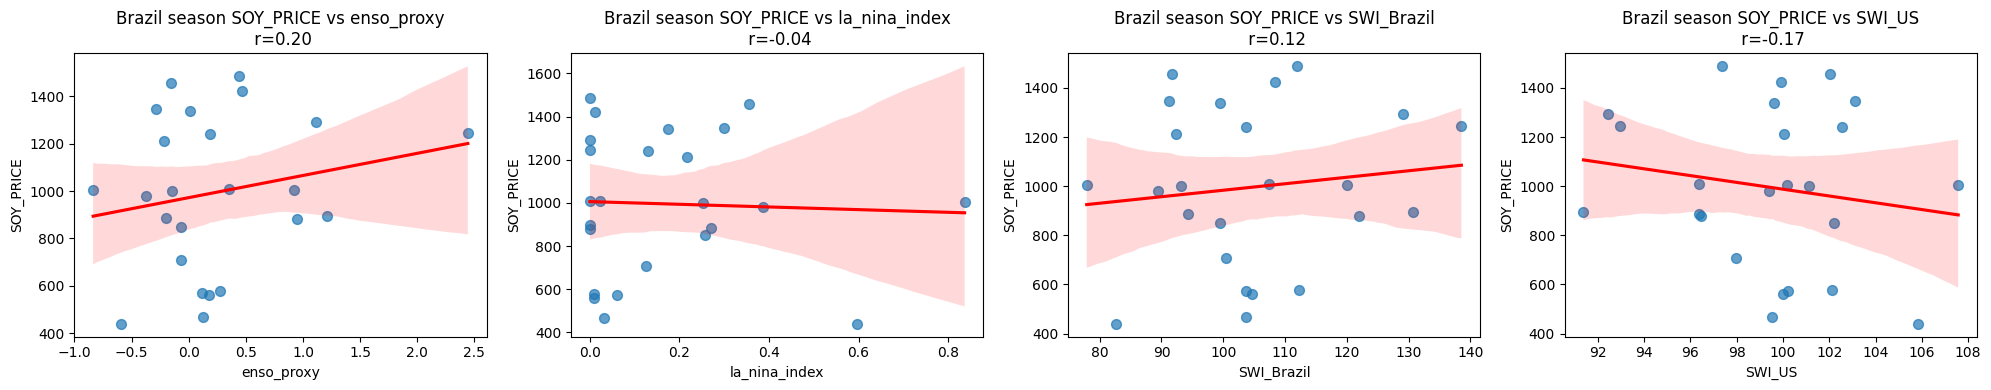

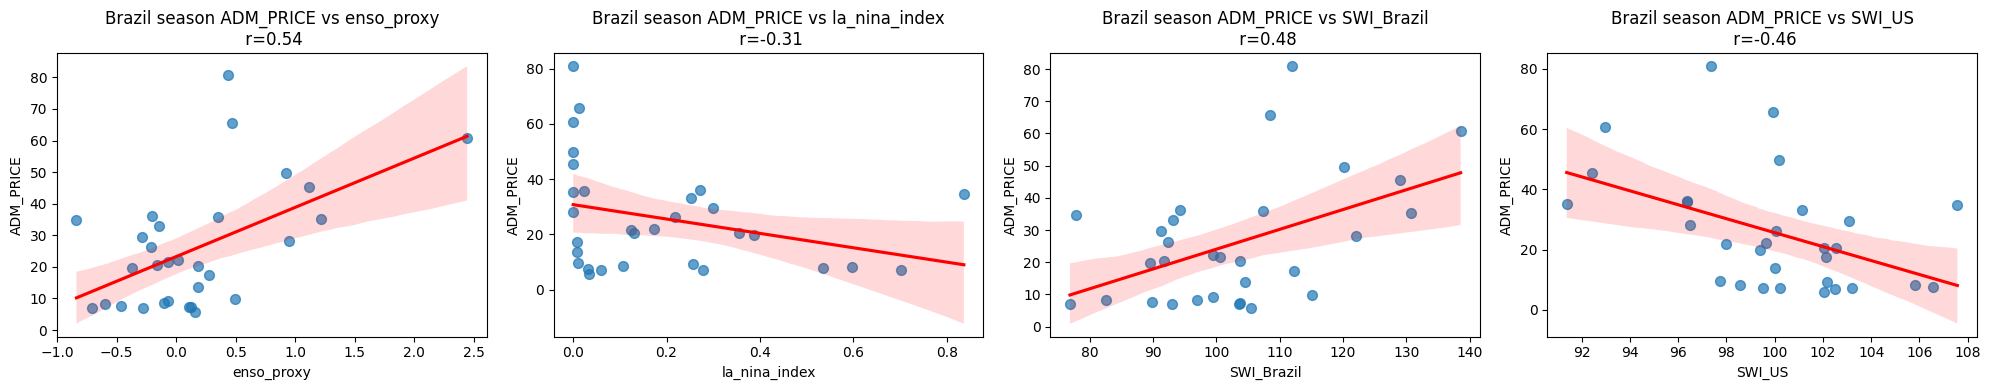

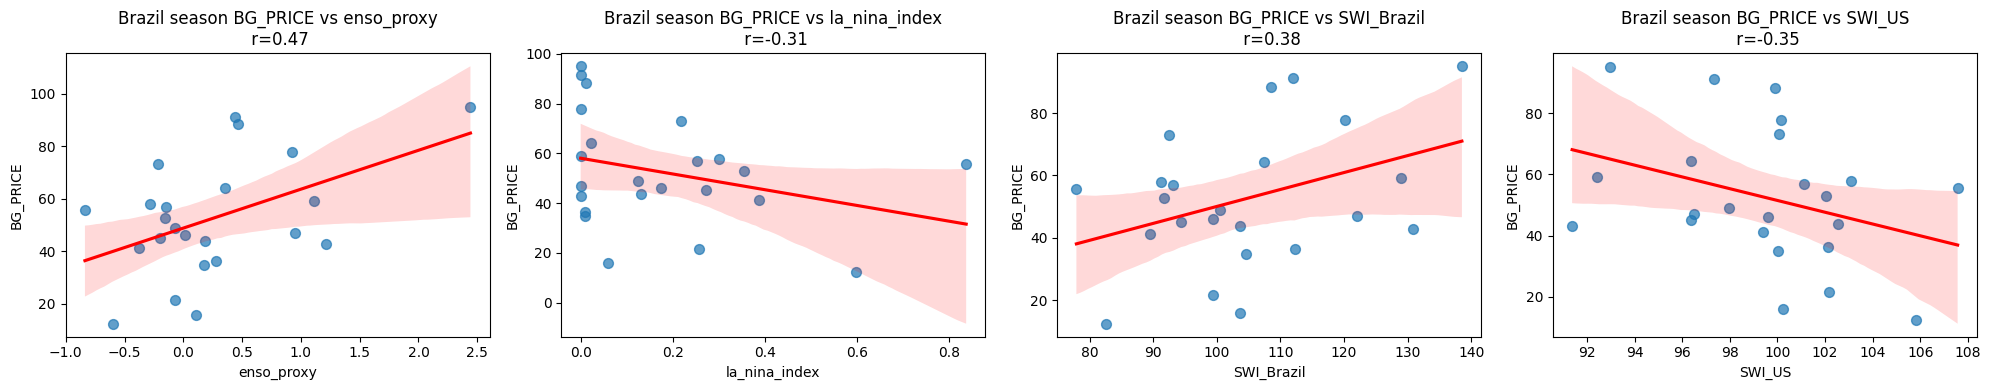

=== Scatter plots – US season (May–Sep) ===


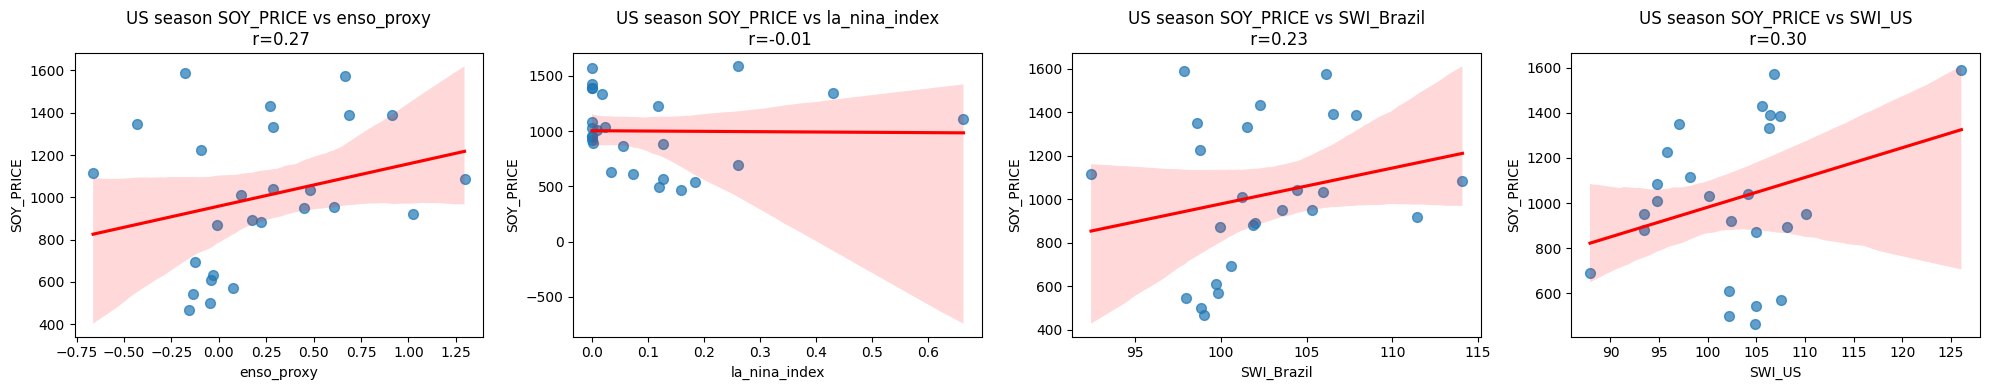

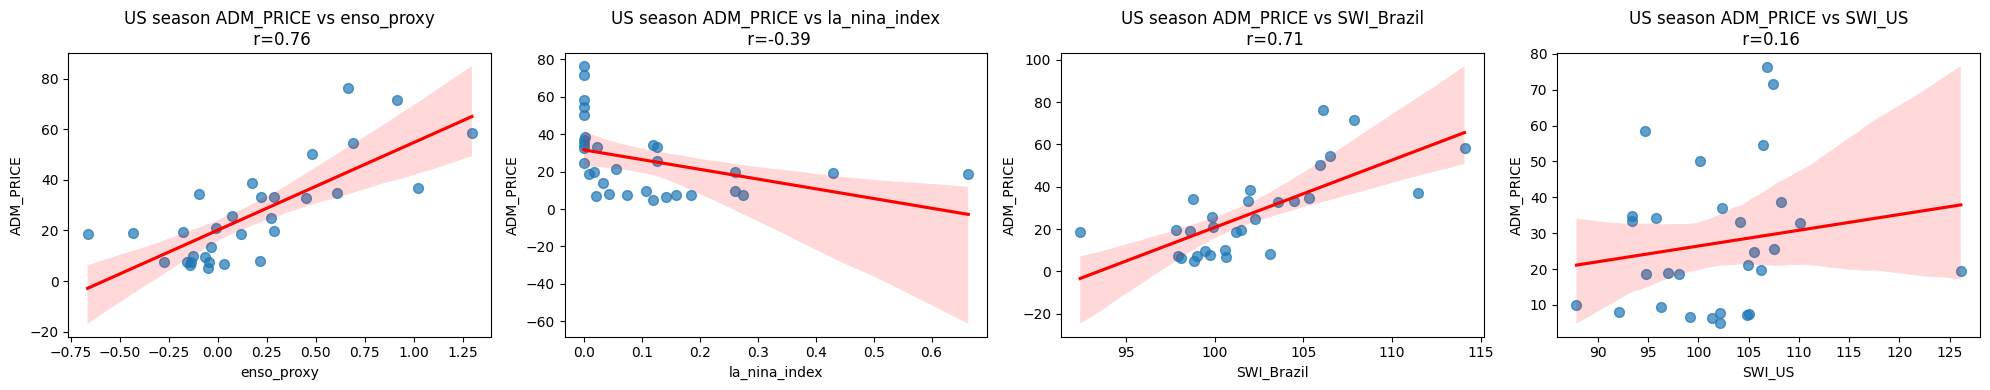

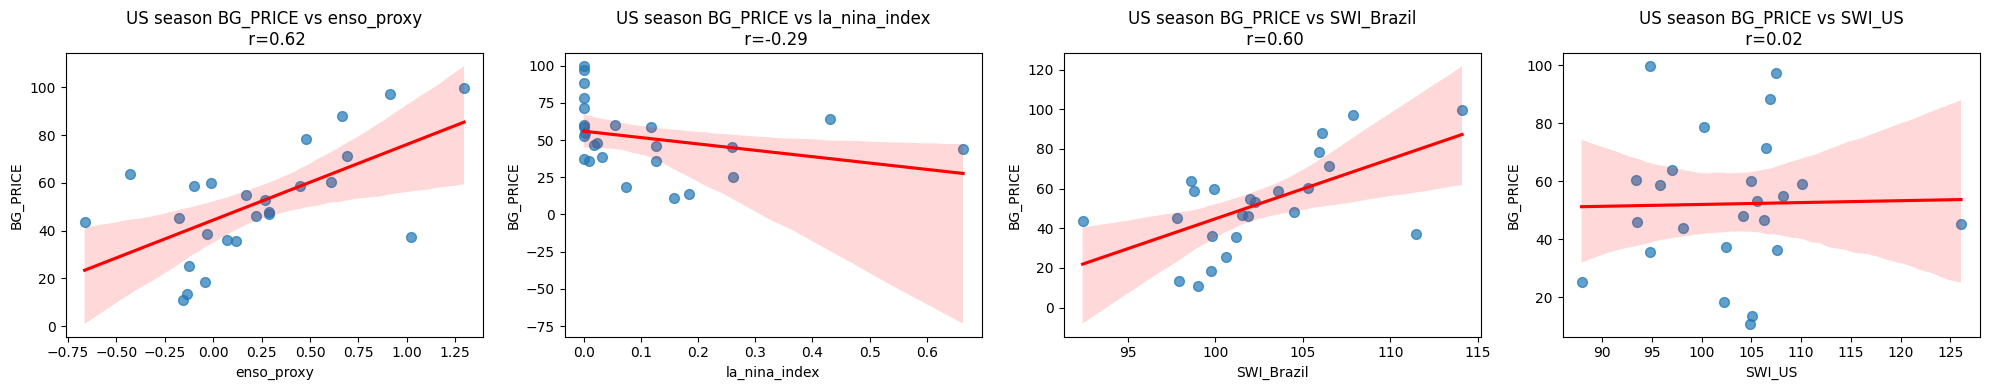

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Helper: scatter matrix for one target
# ==========================
def scatter_plots(season_df, target, variables, title_prefix=""):
    n = len(variables)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4), sharey=False)
    if n == 1:
        axes = [axes]

    for ax, var in zip(axes, variables):
        if var not in season_df.columns:
            continue
        x = season_df[var]
        y = season_df[target]
        sns.regplot(x=x, y=y, ax=ax, scatter_kws={"s":50, "alpha":0.7}, line_kws={"color":"red"})
        ax.set_xlabel(var)
        ax.set_ylabel(target)
        corr = season_df[[target,var]].dropna().corr().iloc[0,1]
        ax.set_title(f"{title_prefix} {target} vs {var}\n r={corr:.2f}")
    plt.tight_layout()
    plt.show()

# ==========================
# Plot for Brazil season
# ==========================
variables = ["enso_proxy","la_nina_index","SWI_Brazil","SWI_US"]

print("=== Scatter plots – Brazil season (Oct–Mar) ===")
scatter_plots(season_br, "SOY_PRICE", variables, title_prefix="Brazil season")
scatter_plots(season_br, "ADM_PRICE", variables, title_prefix="Brazil season")
scatter_plots(season_br, "BG_PRICE",  variables, title_prefix="Brazil season")

# ==========================
# Plot for US season
# ==========================
print("=== Scatter plots – US season (May–Sep) ===")
scatter_plots(season_us, "SOY_PRICE", variables, title_prefix="US season")
scatter_plots(season_us, "ADM_PRICE", variables, title_prefix="US season")
scatter_plots(season_us, "BG_PRICE",  variables, title_prefix="US season")
